In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import string
from tqdm import tqdm
from bs4 import BeautifulSoup
from matplotlib import rcParams
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
from collections import Counter
from nltk import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.combine import SMOTETomek
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss,accuracy_score, classification_report, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

%matplotlib inline
rcParams["figure.figsize"] = 8,8

In [4]:
df = pd.read_csv("alexa.csv", sep='\t')
print("There are {} rows & {} columns in our data-set.".format(df.shape[0],df.shape[1]))
df.head()

There are 3150 rows & 5 columns in our data-set.


,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3150 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


So, there isn't any missing value in data-set.

## EDA {Exploratory Data Analysis} :-

### Ratings Distribution :-

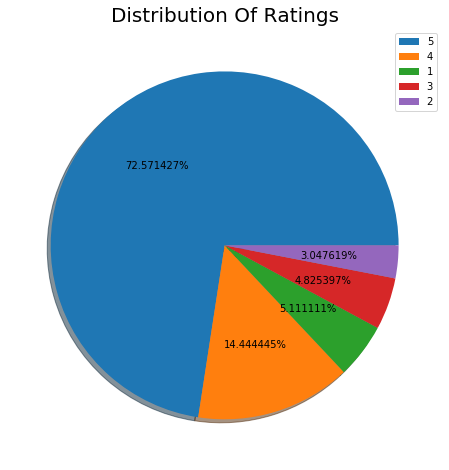

In [6]:
plt.Figure(figsize=(8,8))
plt.pie(df.rating.value_counts(), shadow=True, autopct='%f%%')
plt.title("Distribution Of Ratings", fontsize=20)
plt.legend(["5","4","1","3","2"])
plt.show()

So, we can see 72.57% of data points only belong to rating 5. After that data points belonged to rating 4 are highest, followed by rating 1 and so on.<br>
Here, if we sum up positve Vs negative ratings then we can easily found out that the data set is highly imbalanced i.e. highly biased towards positive side.<br><br>
> I will be taking rating (1,2) on negative side whereas rating (3,4,5) on positive side.

In [7]:
positive_rating = sum(df.rating.value_counts()) - (df.rating.value_counts()[1] + df.rating.value_counts()[2])
negative_rating = df.rating.value_counts()[1] + df.rating.value_counts()[2]
print("The length of data-points of :-\n Positive Rating -> {}\n Negative Rating -> {}".format(positive_rating, negative_rating))

The length of data-points of :-
 Positive Rating -> 2893
 Negative Rating -> 257


### Feedback Column :-

The length of data-points belonged to :-
 1 class -> 2893
 0 class -> 257


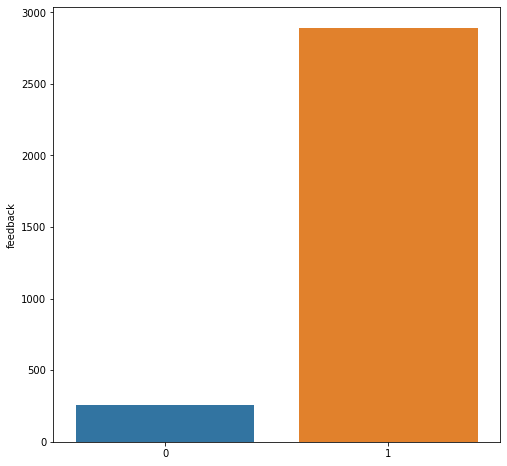

In [8]:
sns.barplot(x=df.feedback.value_counts().index, y=df.feedback.value_counts())
print("The length of data-points belonged to :-\n 1 class -> {}\n 0 class -> {}".format(df.feedback.value_counts()[1], df.feedback.value_counts()[0]))
plt.show()

Now, we can see that the ratio of data-points of (0 & 1) class of feedback column is equal to the ratio of (positive & negative) class.<br>
But we still need to verify that all the data points who have ratings less than 3 do belong to only 0 class of feedback & ratings more than 2 do belong to only 1 class of feedback.<br>

> We can check this by separting our data-frame into 2 segments according to the feedback column.

In [9]:
feedback_0 = df[df.feedback == 0]
feedback_1 = df[df.feedback == 1]
print("The ratings fall under 1 class feedback data-frame are :-", feedback_1.rating.unique())
print("The ratings fall under 0 class feedback data-frame are :-", feedback_0.rating.unique())

The ratings fall under 1 class feedback data-frame are :- [5 4 3]
The ratings fall under 0 class feedback data-frame are :- [2 1]


This proves that all the data-points who have rating less than 3 do belong to 0 class of feedback & the ones who have rating higher than 2 do belong to 1 class of feedback. So, this means that we are already having feedback column where positive & negative ones are distributed.

### Variation Column :-

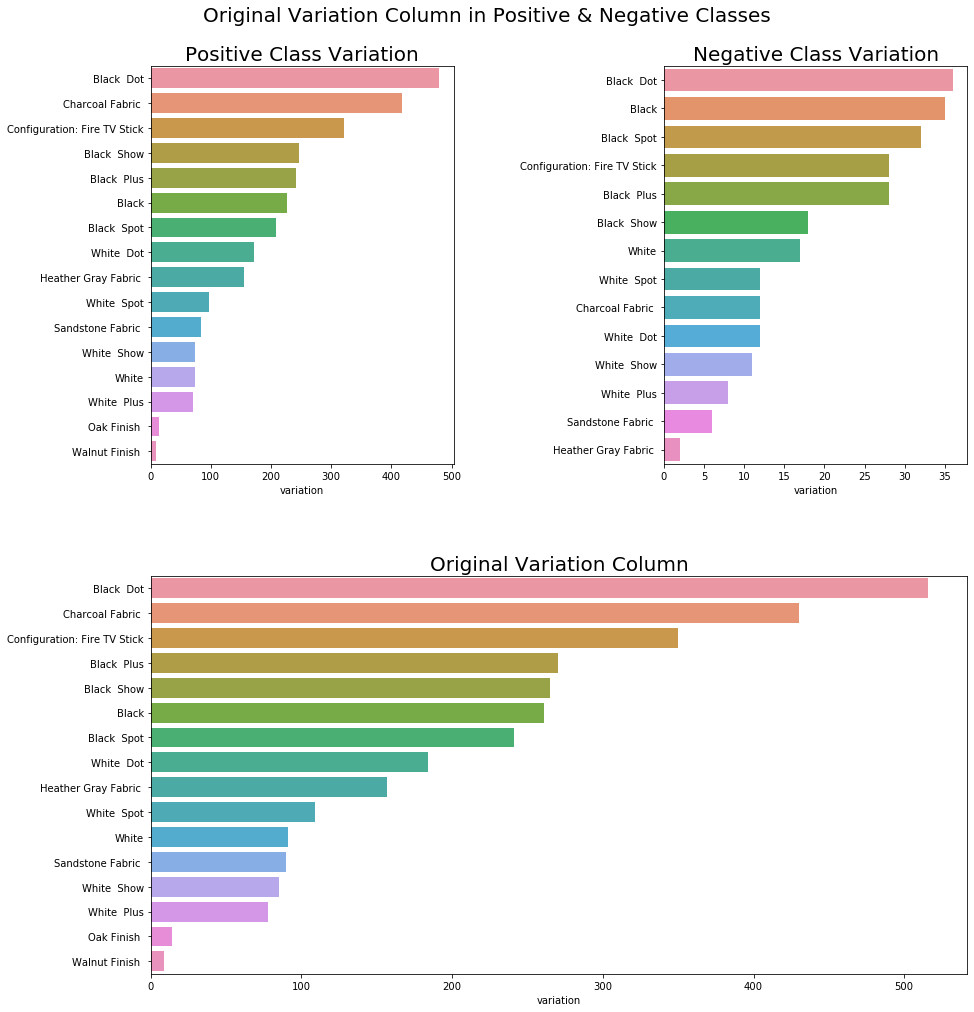

In [8]:
fig = plt.figure(figsize=(15,15))

ax1 = plt.subplot(221)
sns.barplot(x=feedback_1.variation.value_counts(),
            y=feedback_1.variation.value_counts().index, ax=ax1).set_title("Positive Class Variation", fontsize=20)

ax2 = plt.subplot(222)
sns.barplot(x=feedback_0.variation.value_counts(),
            y=feedback_0.variation.value_counts().index, ax=ax2).set_title("Negative Class Variation", fontsize=20)

ax3 = plt.subplot(212)
sns.barplot(y=df.variation.value_counts().index,
            x=df.variation.value_counts(), ax=ax3).set_title("Original Variation Column", fontsize=20)
plt.suptitle("Original Variation Column in Positive & Negative Classes", fontsize=20)
plt.tight_layout(pad=6)
plt.show()

### Verified Reviews Column :-

In [11]:
len_list_words_1 = []
df.verified_reviews = df.verified_reviews.apply(lambda x: x.lower())
for i in df.verified_reviews.values:
    i = len(i.split())
    len_list_words_1.append(i)

original_words_info = {"Maximum Length": max(len_list_words_1),"Mean Length":  round(np.mean(len_list_words_1), 2), "Minimum Length": min(len_list_words_1)}
print("Original Verified Reviews Column :-", original_words_info,"\n")

# X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X

len_list_words_2 = []
feedback_0.verified_reviews = feedback_0.verified_reviews.apply(lambda x: x.lower())
for i in feedback_0.verified_reviews.values:
    i = len(i.split())
    len_list_words_2.append(i)

feedback_0_words_info = {"Maximum Length": max(len_list_words_2),"Mean Length":  round(np.mean(len_list_words_2), 2), "Minimum Length": min(len_list_words_2)}
print("Negative Class Verified Reviews Column :-", feedback_0_words_info,"\n")

# X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X

len_list_words_3 = []
feedback_1.verified_reviews = feedback_1.verified_reviews.apply(lambda x: x.lower())
for i in feedback_1.verified_reviews.values:
    i = len(i.split())
    len_list_words_3.append(i)

feedback_1_words_info = {"Maximum Length": max(len_list_words_3),"Mean Length":  round(np.mean(len_list_words_3), 2), "Minimum Length": min(len_list_words_3)}
print("Positive Class Verified Reviews Column :-", feedback_1_words_info)

Original Verified Reviews Column :- {'Maximum Length': 526, 'Mean Length': 25.29, 'Minimum Length': 0} 

Negative Class Verified Reviews Column :- {'Maximum Length': 307, 'Mean Length': 40.26, 'Minimum Length': 0} 

Positive Class Verified Reviews Column :- {'Maximum Length': 526, 'Mean Length': 23.96, 'Minimum Length': 0}


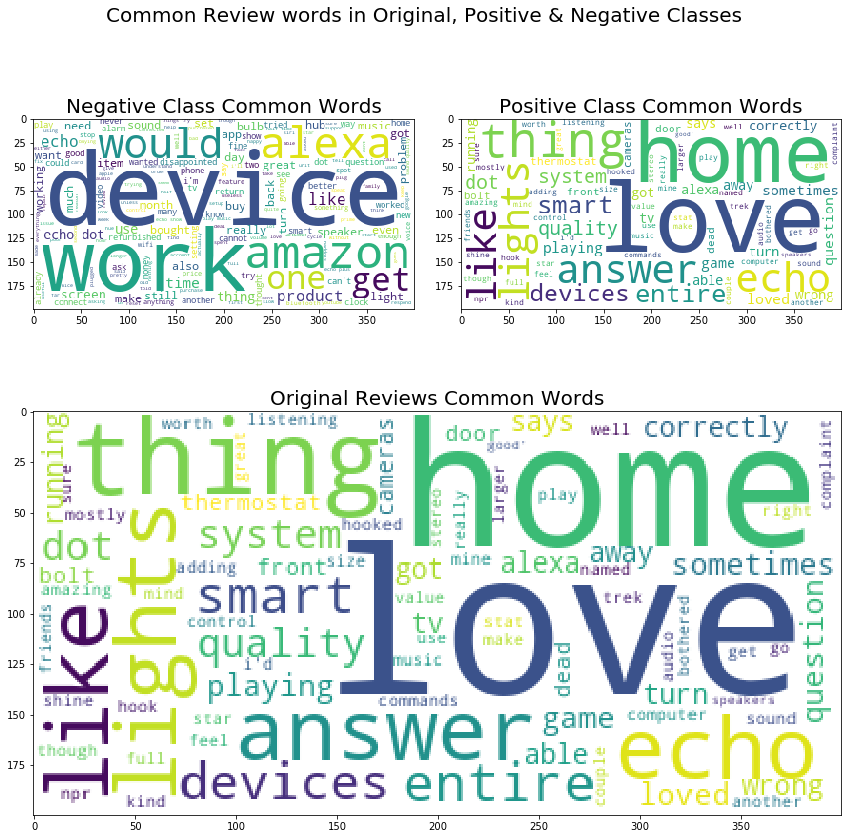

In [10]:
def produce_wordcloud(data, title=None):
    stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
    wordcloud = WordCloud(stopwords=stopwords, max_font_size=None, random_state=2, background_color="white").generate(str(data))
    return wordcloud

fig = plt.figure(figsize=(12,12))

ax1 = plt.subplot(221)
negative_class_wordcloud = produce_wordcloud(feedback_0.verified_reviews.values)
ax1.imshow(negative_class_wordcloud)
ax1.set_title("Negative Class Common Words", fontsize=20)

ax2 = plt.subplot(222)
positive_class_wordcloud = produce_wordcloud(feedback_1.verified_reviews.values)
ax2.imshow(positive_class_wordcloud)
ax2.set_title("Positive Class Common Words", fontsize=20)

ax2 = plt.subplot(212)
original_wordcloud = produce_wordcloud(df.verified_reviews.values)
ax2.imshow(original_wordcloud)
ax2.set_title("Original Reviews Common Words", fontsize=20)
plt.suptitle("Common Review words in Original, Positive & Negative Classes", fontsize=20)
plt.tight_layout(pad=1.5)
plt.show()

>As data-set is highly biased towards **Positive Class** that is why there are many similarities among **Positive Class & Original Columns** in **Exploratory Data Analysis.**

## Data Cleaning & Pre-processing :-

### Pre-processing Verified Reviews :

In [12]:
print(df.verified_reviews[10], '\n')
print("X"+"--X"*40, '\n')
print(df.verified_reviews[100], '\n')
print("X"+"--X"*40, '\n')
print(df.verified_reviews[1000])

i sent it to my 85 year old dad, and he talks to it constantly. 

X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X 

great fun getting to know all the functions of this product.  wow -- family fun and homework help.  talking with other grandchildren,who also have an echo, is a huge bonus.  can't wait to learn more and more and more 

X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X 

it's great for music, a little hard to figure out how it works.


In [17]:
stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren','couldn', 'didn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'ma', 'mightn', 'mustn', 'needn', 'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn']
lemmatizer = WordNetLemmatizer()

In [18]:
preprocessed_reviews = []
words = []

for sentances in tqdm(df.verified_reviews.values):
    sentances = re.sub(r"http\S+", "", sentances)
    sentances = re.sub("\S*\d\S*", "", sentances).strip()
    sentances = re.sub('[^A-Za-z]+', ' ', sentances)
    sentances = " ".join(lemmatizer.lemmatize(word) for word in sentances.split() if word not in stopwords)
    preprocessed_reviews.append(sentances.strip())

# preprocessed_reviews = pd.Series(preprocessed_reviews)
# preprocessed_reviews.name = "preprocessed_reviews"

100%|██████████| 3150/3150 [00:00<00:00, 5272.82it/s]


In [19]:
print(preprocessed_reviews[10], '\n')
print("X"+"--X"*40, '\n')
print(preprocessed_reviews[100], '\n')
print("X"+"--X"*40, '\n')
print(preprocessed_reviews[1000])

sent year old dad talk constantly 

X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X 

great fun getting know function product wow family fun homework help talking grandchild also echo huge bonus wait learn 

X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X 

great music little hard figure work


### Top 15 Frequent Words In Reviews :-

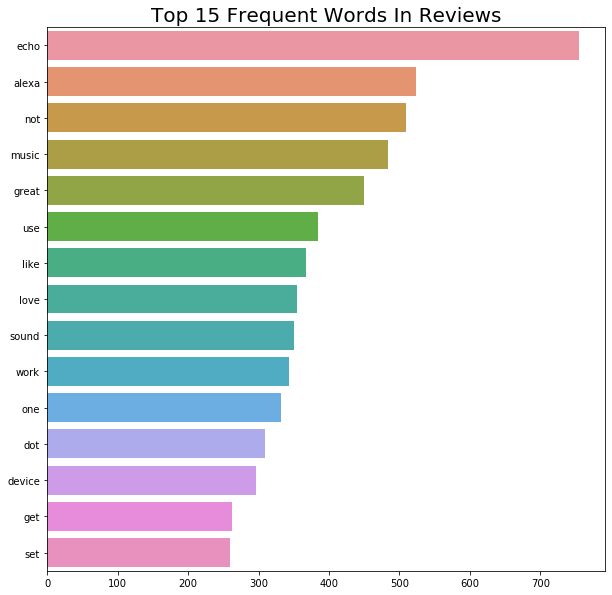

In [15]:
words = ''.join(word for word in preprocessed_reviews)
words = nltk.word_tokenize(words)
words = pd.Series(words)

plt.figure(figsize=(10,10))
sns.barplot(x=words.value_counts()[:15], y=words.value_counts()[:15].index)
plt.title("Top 15 Frequent Words In Reviews", fontsize=20)
plt.show()

> **As our data-set is highly imbalanced so we can't train our model like that. So, we will have to use some techniques to handle our imbalanced data-set. Thus, we will vectorize our data & will store it in a new data-frame because for using techniques to handle imbalanced data we need all data in integers or floats format.**

## Featurization :-
### TF-IDF (Converting Reviews Into Vectors)

In [16]:
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=5)
final_reviews = tfidf.fit_transform(preprocessed_reviews).toarray()

final_reviews = pd.DataFrame(final_reviews, columns=tfidf.get_feature_names())
print("So, now the rows are {} & columns are {}.".format(final_reviews.shape[0], final_reviews.shape[1]))
final_reviews.head()

So, now the rows are 3150 & columns are 1737.


,ability,able,able listen,able play,able see,able set,able tell,able use,able watch,absolutely,...,would recommend,wrong,yard,year,year old,yes,yet,youtube,youtube video,yr
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.184338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.26256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.295826
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


### Vectorizing Categorical Data {Variation Column} :
Now, we will perform vectorization on Variation column as it is having categorical data so will try Mean Encoding to convert categories into vectors.

In [17]:
print(df.groupby(["variation"])["feedback"].mean().duplicated().any(), "means that here mean value is repeated")
df.groupby(["variation"])["feedback"].mean()

True means that here mean value is repeated


variation
Black                           0.865900
Black  Dot                      0.930233
Black  Plus                     0.896296
Black  Show                     0.932075
Black  Spot                     0.867220
Charcoal Fabric                 0.972093
Configuration: Fire TV Stick    0.920000
Heather Gray Fabric             0.987261
Oak Finish                      1.000000
Sandstone Fabric                0.933333
Walnut Finish                   1.000000
White                           0.813187
White  Dot                      0.934783
White  Plus                     0.897436
White  Show                     0.870588
White  Spot                     0.889908
Name: feedback, dtype: float64

> We cannot use Mean Encoding for Variation Column as you can see the category {Oak Finish & Walnut Finish} have same mean values with respect to Feedback(Target) Column.

**So, now lets try Count/Frequency Encoding for this Variation Column.**

In [18]:
count_variation = df.groupby(["variation"])["feedback"].count()
print(count_variation.duplicated().any())  # So, this shows that no value is repeated here.
count_variation

False


variation
Black                           261
Black  Dot                      516
Black  Plus                     270
Black  Show                     265
Black  Spot                     241
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Heather Gray Fabric             157
Oak Finish                       14
Sandstone Fabric                 90
Walnut Finish                     9
White                            91
White  Dot                      184
White  Plus                      78
White  Show                      85
White  Spot                     109
Name: feedback, dtype: int64

>So, I have decided to use **Count Encoding** as there are **no repeated values** which were in Mean Encoding.

**Now, lets make a final data frame for proceeding further.**

In [19]:
df["preprocessed_variation"] = df.variation.map(count_variation)

final_df = pd.concat([df, final_reviews], axis=1)
final_df = final_df.drop(["date", "rating", "variation", "verified_reviews"], axis=1)
print("Now, the rows are {} & columns are {}.".format(final_df.shape[0], final_df.shape[1]))
final_df.head()

Now, the rows are 3150 & columns are 1738.


,feedback,preprocessed_variation,ability,able,able listen,able play,able see,able set,able tell,able use,...,would recommend,wrong,yard,year,year old,yes,yet,youtube,youtube video,yr
0,1,430,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,1,430,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,1,9,0.0,0.184338,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.26256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,1,430,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.295826
4,1,430,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


>So, now our **Final Data-Frame** is all set to **proceed further.**

## Handling Imabalanced Data :-
As we saw above that our **Output Classes** are highly imbalanced. So, because of that model can be **biased** towards **Class 1(Positive Class)** & to stop this we will here apply some **techniques & methods.**<br><br>
Here, I am going to use **Combination of Over & Under Sampling Techniques** to handle our imbalanced data-set & within it I am going to use **Smote Tomek Method.**<br><br>
First, lets specify the Input(X) & Output(y).<br>
Second, will take a look over the classes distribution which shows the amount of Imbalanced Data & then will apply Smote Tomek Method.

In [20]:
X_imbal = final_df.drop(["feedback"], axis=1)
y_imbal = final_df["feedback"]

print("The length of data-points belonged to :-\n 1 (Positive class) -> {} \n 0 (Negative class) -> {}".format(
    y_imbal.value_counts()[1], y_imbal.value_counts()[0]), "\n")

print("The Percentage of Classes Distribution is :-\n 1 (Positive class) -> {} \n 0 (Negative class) -> {}".format(
    round(y_imbal.value_counts()[1]/df.shape[0]*100, 2),
                                 round(y_imbal.value_counts()[0]/df.shape[0]*100, 2)))

The length of data-points belonged to :-
 1 (Positive class) -> 2893 
 0 (Negative class) -> 257 

The Percentage of Classes Distribution is :-
 1 (Positive class) -> 91.84 
 0 (Negative class) -> 8.16


After applying **Smote Tomek Method** the **Percentage of Classes Distribution** will be **(50 - 50 %)** which is right now **(91.84 - 8.16 %).**<br> This means that this method will **replicate the minortiy class {0(Negative Class)} data-points** to make **Class Distribution equal & to make Data Balanced.**

In [21]:
smk = SMOTETomek(random_state=42)
X, y = smk.fit_sample(X_imbal, y_imbal)

In [22]:
print("The length of data-points belonged to :-\n 1 (Positive class) -> {} \n 0 (Negative class) -> {}".format(
    y.value_counts()[1], y.value_counts()[0]), "\n")

print("The Percentage of Classes Distribution is :-\n 1 (Positive class) -> {} \n 0 (Negative class) -> {}".format(
    round(y.value_counts()[1]/y.shape[0]*100, 2), round(y.value_counts()[0]/y.shape[0]*100, 2)))

The length of data-points belonged to :-
 1 (Positive class) -> 2893 
 0 (Negative class) -> 2893 

The Percentage of Classes Distribution is :-
 1 (Positive class) -> 50.0 
 0 (Negative class) -> 50.0


> Now, finally we are ready to train-test-split data & then go for creating models.

## Train-Test-Split :-

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, stratify=y, random_state=42)
print("X_train :-\n Rows - {}\n Columns - {}\n\n".format(X_train.shape[0], X_train.shape[1]))
print("y_train :-\n Rows - {}\n\n".format(y_train.shape[0]))
print("X_test :-\n Rows - {}\n Columns - {}\n\n".format(X_test.shape[0], X_test.shape[1]))
print("y_test :-\n Rows - {}\n\n".format(y_test.shape[0]))

X_train :-
 Rows - 4628
 Columns - 1737


y_train :-
 Rows - 4628


X_test :-
 Rows - 1158
 Columns - 1737


y_test :-
 Rows - 1158




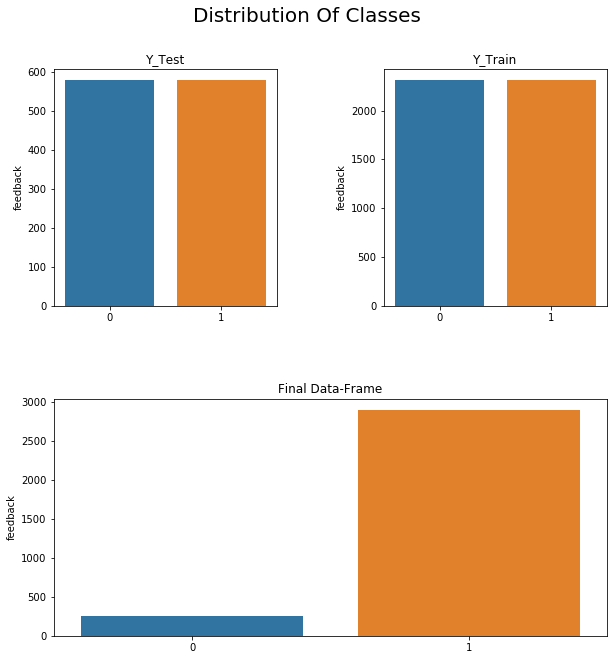

In [24]:
fig = plt.figure(figsize=(10,10))

ax1 = plt.subplot(212)
sns.barplot(x=final_df.feedback.value_counts().index, y=final_df.feedback.value_counts(), ax=ax1).set_title("Final Data-Frame")

ax2 = plt.subplot(222)
sns.barplot(x=y_train.value_counts().index, y=y_train.value_counts(), ax=ax2).set_title("Y_Train")

ax3 = plt.subplot(221)
sns.barplot(x=y_test.value_counts().index, y=y_test.value_counts(), ax=ax3).set_title("Y_Test")

plt.suptitle("Distribution Of Classes", fontsize=20)
plt.tight_layout(pad=6.0)
plt.show()

**X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X**
## Random Model :-

In [28]:
# both in np.zeros, np.random.rand (row, column) parameters are given.
random_predicted_y = np.zeros((len(y_test), 2))
for i in range(len(y_test)):
    rand_probs = np.random.rand(1,2)
    random_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])  # code explained in next cell
print("Log loss on Test Data using Random Model",log_loss(y_test, random_predicted_y, eps=1e-15))

Log loss on Test Data using Random Model 0.8668881275764944


In [30]:
"""Only to understand the code of Random Model Predicted Variable."""
print("rand_probs :-",rand_probs,"\n")
print("sum(rand_probs) :-",sum(rand_probs),"\n")
print("sum(sum(rand_probs)) :-", sum(sum(rand_probs)),"\n")
print("rand_probs/sum(sum(rand_probs)) :- ", rand_probs/sum(sum(rand_probs)),"\n")
print("(rand_probs/sum(sum(rand_probs)))[0] :- ",(rand_probs/sum(sum(rand_probs)))[0])

rand_probs :- [[0.83124558 0.36764724]] 

sum(rand_probs) :- [0.83124558 0.36764724] 

sum(sum(rand_probs)) :- 1.1988928166847037 

rand_probs/sum(sum(rand_probs)) :-  [[0.69334436 0.30665564]] 

(rand_probs/sum(sum(rand_probs)))[0] :-  [0.69334436 0.30665564]


**X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X**
## Gradient Boosting Decision Tree :-

In [31]:
from datetime import datetime
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

**On default parameters GBDT** took 19.15 seconds (approx.) to train model. Few parameters are :-<br>
**learning_rate :-** 0.1<br>
**n_estimators :-** 100 (number of trees).<br>
**max_depth :-** 3<br>
**min_samples_split :-** 2<br>
**min_samples_leaf :-** 1<br>
**random_state :-** 42<br>
**subsample :-** 1.0<br><br>
**Accuracy score :-** 91.36442141623489<br>
**Roc-Auc score :-** 91.36442141623489<br>
**Confusion Matrix :-** [ [514  65] [ 35 544] ]<br>
**Log-Loss score :-** 2.9826680598653126<br><br>
**X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X**<br>
With following params it took 20 minutes and 52.21 seconds (approx.) :-<br>
**learning_rate :-** [10******x for x in range(-5,1)]<br>
**n_estimators :-** [50, 100, 200]<br>
**max_depth :-** [3,4]<br><br>
**Accuracy score :-** 96.02763385146805<br>
**Roc-Auc score :-** 96.02763385146804<br>
**Confusion Matrix :-** [ [570   9] [ 37 542] ]<br>
**Log-Loss score :-** 1.3720128761163763<br><br>
**X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X**<br>
These parameters are not tried until now :-<br>
**learning_rate :-** [10******x for x in range(-5,1)]<br>
**n_estimators* :-** [50, 100, 200, 400, 500]<br>
**max_depth :-** [3,4,5,8,10]<br>
**min_samples_split :-** [1,2,3,4]<br><br>

**On Default Parameters :-**

In [38]:
# gbc = GradientBoostingClassifier(random_state=42)
# gbc.fit(X_train, y_train)
# print("Accuracy score :-", accuracy_score(y_test, gbc.predict(X_test))*100)
# print("Roc-Auc score :-", roc_auc_score(y_test, gbc.predict(X_test))*100)
# print("Confusion Matrix :-", confusion_matrix(y_test, gbc.predict(X_test)))
# print("Log-Loss score :-", log_loss(y_test, gbc.predict(X_test)))

Accuracy score :- 91.36442141623489
Roc-Auc score :- 91.36442141623489
Confusion Matrix :- [[514  65]
 [ 35 544]]
Log-Loss score :- 2.9826680598653126


**Applying a few Parameters this time :-**

In [32]:
params = {
    "learning_rate": [10**x for x in range(-5,1)],
    "n_estimators": [50, 100, 200],
    "max_depth": [3,4]
}

In [33]:
start_time = timer(None)
gbc = GradientBoostingClassifier()
rscv = RandomizedSearchCV(estimator=gbc, param_distributions=params, random_state=42, n_iter=10)
rscv.fit(X_train, y_train)
timer(start_time)


 Time taken: 0 hours 20 minutes and 52.21 seconds.


In [36]:
print("Accuracy score :-", accuracy_score(y_test, rscv.predict(X_test))*100)
print("Roc-Auc score :-", roc_auc_score(y_test, rscv.predict(X_test))*100)
print("Confusion Matrix :-", confusion_matrix(y_test, rscv.predict(X_test)))
print("Log-Loss score :-", log_loss(y_test, rscv.predict(X_test)))

Accuracy score :- 96.02763385146805
Roc-Auc score :- 96.02763385146804
Confusion Matrix :- [[570   9]
 [ 37 542]]
Log-Loss score :- 1.3720128761163763


**X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X**
## SGD Classifier :-

In [31]:
alpha = [10**-i for i in range(-5,1)]
for i in alpha:
    sgd = SGDClassifier(loss="log",alpha=i, random_state=42, verbose=3)
    sgd.fit(X_train, y_train)
    

-- Epoch 1
Norm: 0.00, NNZs: 1737, Bias: 0.028104, T: 4628, Avg. loss: 1.088426
Total training time: 0.08 seconds.
-- Epoch 2
Norm: 0.00, NNZs: 1737, Bias: 0.028104, T: 9256, Avg. loss: 0.693163
Total training time: 0.15 seconds.
-- Epoch 3
Norm: 0.00, NNZs: 1737, Bias: 0.028104, T: 13884, Avg. loss: 0.693144
Total training time: 0.19 seconds.
-- Epoch 4
Norm: 0.00, NNZs: 1737, Bias: 0.028104, T: 18512, Avg. loss: 0.693141
Total training time: 0.23 seconds.
-- Epoch 5
Norm: 0.00, NNZs: 1737, Bias: 0.028104, T: 23140, Avg. loss: 0.693144
Total training time: 0.26 seconds.
-- Epoch 6
Norm: 0.00, NNZs: 1737, Bias: 0.028104, T: 27768, Avg. loss: 0.693139
Total training time: 0.30 seconds.
-- Epoch 7
Norm: 0.00, NNZs: 1737, Bias: 0.028104, T: 32396, Avg. loss: 0.693140
Total training time: 0.33 seconds.
Convergence after 7 epochs took 0.33 seconds
-- Epoch 1
Norm: 0.00, NNZs: 1737, Bias: 0.049891, T: 4628, Avg. loss: 1.397458
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 0.00, NNZs: 1

Norm: 0.04, NNZs: 1737, Bias: -0.051264, T: 83304, Avg. loss: 0.795700
Total training time: 0.60 seconds.
-- Epoch 19
Norm: 0.04, NNZs: 1737, Bias: -0.052076, T: 87932, Avg. loss: 0.793611
Total training time: 0.65 seconds.
-- Epoch 20
Norm: 0.04, NNZs: 1737, Bias: -0.052873, T: 92560, Avg. loss: 0.784815
Total training time: 0.69 seconds.
-- Epoch 21
Norm: 0.04, NNZs: 1737, Bias: -0.053633, T: 97188, Avg. loss: 0.779613
Total training time: 0.73 seconds.
-- Epoch 22
Norm: 0.04, NNZs: 1737, Bias: -0.054335, T: 101816, Avg. loss: 0.774069
Total training time: 0.77 seconds.
-- Epoch 23
Norm: 0.04, NNZs: 1737, Bias: -0.055041, T: 106444, Avg. loss: 0.770660
Total training time: 0.81 seconds.
-- Epoch 24
Norm: 0.04, NNZs: 1737, Bias: -0.055735, T: 111072, Avg. loss: 0.761971
Total training time: 0.84 seconds.
-- Epoch 25
Norm: 0.04, NNZs: 1737, Bias: -0.056310, T: 115700, Avg. loss: 0.756171
Total training time: 0.88 seconds.
-- Epoch 26
Norm: 0.04, NNZs: 1737, Bias: -0.056837, T: 120328, 

In [32]:
print("Accuracy score :-", accuracy_score(y_test, sgd.predict(X_test))*100)
print("Roc-Auc score :-", roc_auc_score(y_test, sgd.predict(X_test))*100)
print("Confusion Matrix :-", confusion_matrix(y_test, sgd.predict(X_test)))
print("Log-Loss score :-", log_loss(y_test, sgd.predict(X_test)))

Accuracy score :- 50.0
Roc-Auc score :- 50.0
Confusion Matrix :- [[579   0]
 [579   0]]
Log-Loss score :- 17.269388197455342


**X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X**
## Logistic Regression :-

In [33]:
log = LogisticRegression()
log.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [34]:
print("Accuracy score :-", accuracy_score(y_test, log.predict(X_test))*100)
print("Roc-Auc score :-", roc_auc_score(y_test, log.predict(X_test))*100)
print("Confusion Matrix :-", confusion_matrix(y_test, log.predict(X_test)))
print("Log-Loss score :-", log_loss(y_test, log.predict(X_test)))

Accuracy score :- 93.95509499136442
Roc-Auc score :- 93.95509499136443
Confusion Matrix :- [[578   1]
 [ 69 510]]
Log-Loss score :- 2.087836914716044


**X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X**
## Random Forest :-

On default parameters Random Forest Classifier took 5.3 seconds to train model. The parameters which matter :-<br>
learning_rate=0.1.<br>
n_estimators=100 (number of trees).<br>
max_depth=3.<br>
min_samples_split=2.<br>
min_samples_leaf=1.<br>
subsample=1.0.

In [36]:
start_time = timer(None)
rgb = RandomForestClassifier()
rgb.fit(X_train, y_train)
timer(start_time)


 Time taken: 0 hours 0 minutes and 5.23 seconds.


In [37]:
print("Accuracy score :-", accuracy_score(y_test, rgb.predict(X_test))*100)
print("Roc-Auc score :-", roc_auc_score(y_test, rgb.predict(X_test))*100)
print("Confusion Matrix :-", confusion_matrix(y_test, rgb.predict(X_test)))
print("Log-Loss score :-", log_loss(y_test, rgb.predict(X_test)))

Accuracy score :- 96.80483592400691
Roc-Auc score :- 96.80483592400691
Confusion Matrix :- [[573   6]
 [ 31 548]]
Log-Loss score :- 1.1035747186496352


**X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X--X**